# Numerical Differentiation for different dimensions

This iPython Notebook showcases how to compute derivatives of discrete signals, i.e. functions which are only known on a discrete set of points.

Since we don't have an analytical expression of the function we cannot use automatic differentiation (unless, we had fitted the function to a spline or something similar, but this is **not** the strategy taken in this project).

**Current Status**

I've managed to implement a `grad` function which can differentiate any function $f : \mathbb{R}^n \to \mathbb{R}$.

Next step is to allow for multivalued outputs also, $f : \mathbb{R}^n \to \mathbb{R}^m$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def diff(f, x):
    '''Returns three-point estimate (central difference) of derivative of f with respect to x'''
    f_pad = np.hstack([ 3*(f[0] - f[1]) + f[2],
                        f,
                        3*(f[-1] - f[-2]) + f[-3]])
    df = np.diff(f_pad)
    h = np.diff(x[:2])[0]
    return (df[1:] + df[:-1])/(2*h)

# Alternative implementation
# def diff(f,x):
#     df = np.diff(f)
#     h = np.diff(x[:2])[0]
#     dfdx_l = (-3*f[0] + 4*f[1] - f[2])/(2*h)
#     dfdx_c = (df[1:] + df[:-1])/(2*h)
#     dfdx_r = (f[-3] - 4*f[-2] + 3*f[-1])/(2*h)
#     return np.hstack([dfdx_l, dfdx_c, dfdx_r])

In [3]:
def grad(f, *args, axes=None):
    '''
    Returns numerical derivative of N-D array, f, with respect to arguments, *args.

    **Example:**
    Say we have a function, f : R^2 -> R
    of two variables f(x1, x2) returning 1 value.
    The function is defined on a grid of two
    input arrays with shapes x1 ~ (n1, ), x2 ~ (n2, )
    and therefore f has shape f ~ (n1, n2).
    (The grid can be made through `X1, X2 = np.meshgrid(x1, x2, indexing='ij')` )
    
    Using `grad(f, x1, x2)` returns an array of shape ~ (n1, n2, 2)
    containing the estimated partial derivatives of f with respect to x1 and x2.
    Thus, `grad(f, x1, x2)[:, :, 0]` corresponds to ∂f/∂x_1
    and `grad(f, x1, x2)[:, :, 1]` corresponds to ∂f/∂x_2.

    You may also use `grad(f, x2, axes=[1])` to only get ∂f/∂x_2 ... and so on.
    '''
    _f = f.squeeze()
    
    def dtake(a, index, axis):
        '''numpy take a single index but keep dimensions.'''
        dims = [1 if i == axis else s for i, s in enumerate(a.shape)]
        return np.take(a=a, indices=index, axis=axis).reshape(dims)
    
    def take_many(f, indeces, axis):
        return (*[dtake(f, i, axis) for i in indeces], )
    
    grad_f = np.zeros((*_f.shape, len(args)))
    if axes is None:
        axes = np.arange(len(args))
    
    for i, (axis, xi) in enumerate(zip(axes, args)):
        f0, f1, f2, fm1, fm2, fm3 = take_many(_f, [0, 1, 2, -1, -2, -3], axis)
        f_pad = np.concatenate([3*(f0 - f1) + f2, _f, 3*(fm1 - fm2) + fm3], axis=axis)
        df_pad = np.diff(f_pad, axis=axis)
        h = np.diff(xi[:2])[0]
        grad_f_i = (np.take(df_pad, np.arange(1, df_pad.shape[axis]), axis=axis)
         + np.take(df_pad, np.arange(0, df_pad.shape[axis] - 1), axis=axis))/(2*h)
        grad_f[..., i] = grad_f_i

    return grad_f.squeeze()

## Examples

### $f : \mathbb{R} \to \mathbb{R}$

Consider:
$$
f(x) = \sin(a x) \\
f'(x) = a \cos(a x) \\
f''(x) = - a^2 \sin(ax)
$$

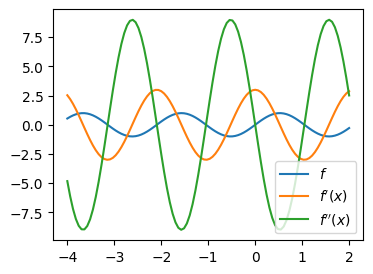

In [4]:
a = 3
x = np.linspace(-4, 2, 100)
f = np.sin(a*x)
_df = a*np.cos(a*x)
_ddf = -a**2 * np.sin(a*x)
plt.figure(figsize=(4,3))
plt.plot(x, f, label=r"$f$")
plt.plot(x, _df, label=r"$f'(x)$")
plt.plot(x, _ddf, label=r"$f''(x)$")
plt.legend()
plt.show()

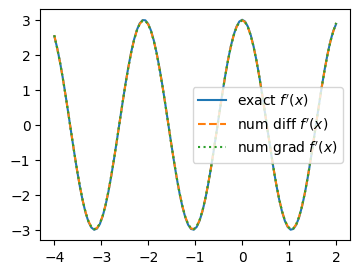

In [5]:
df = diff(f, x)
plt.figure(figsize=(4,3))
plt.plot(x, _df, label=r"exact $f'(x)$")
plt.plot(x, df, '--', label=r"num diff $f'(x)$")
plt.plot(x, grad(f, x), ':', label=r"num grad $f'(x)$")
plt.legend()
plt.show()

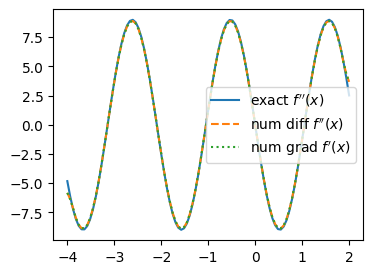

In [6]:
ddf = diff(diff(f, x),x)
plt.figure(figsize=(4,3))
plt.plot(x, _ddf, label=r"exact $f''(x)$")
plt.plot(x, ddf, '--', label=r"num diff $f''(x)$")
plt.plot(x, grad(grad(f, x), x), ':', label=r"num grad $f'(x)$")
plt.legend()
plt.show()

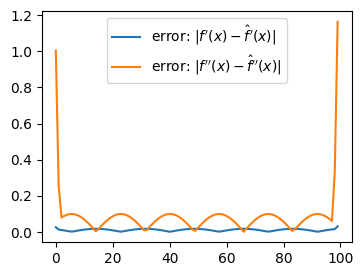

In [7]:
plt.figure(figsize=(4,3))
plt.plot(np.abs(_df - df), label="error: $|f'(x) - \hat{f}'(x)|$")
plt.plot(np.abs(_ddf - ddf), label="error: $|f''(x) - \hat{f}''(x)|$")
plt.legend()
plt.show()

### $f : \mathbb{R}^2 \to \mathbb{R}$

Consider:
$$
f(x_1, x_2) = x_1 \sin(a x_2) \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2)
\end{array}
\right)
$$

In [16]:
a=3
_f = lambda x1, x2 : x1 * np.sin(a*x2)
_df = lambda x1, x2 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2)), axis=-1)

x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(0, 2/a*np.pi, 200)
X1, X2 = np.meshgrid(x1, x2, indexing='ij')
f = _f(X1, X2)

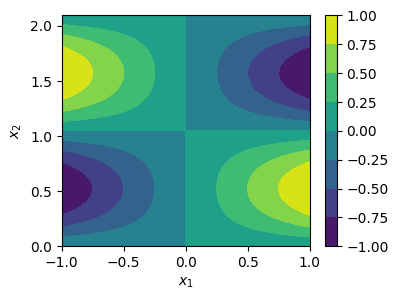

In [17]:
plt.figure(figsize=(4,3))
plt.contourf(X1, X2, f)
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [15]:
# How to calculate the derivative without using the grad function
n1, n2 = f.shape
df = np.zeros((n1, n2, 2))
for i in range(n1):
    df[i, :, 1] = diff(f[i, :], x2)
for j in range(n2):
    df[:, j, 0] = diff(f[:, j], x1)

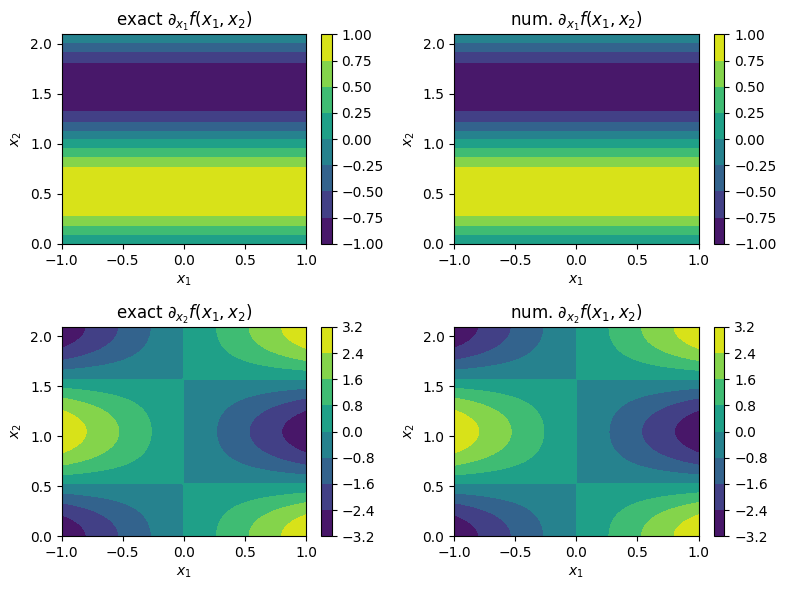

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
cont = ax[0,0].contourf(X1, X2, _df(X1, X2)[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2)$')

cont = ax[0,1].contourf(X1, X2, df[:, :, 0])
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$')

cont = ax[1, 0].contourf(X1, X2, _df(X1, X2)[:, :, 1])
plt.colorbar(cont)
ax[1,0].set_xlabel(r'$x_1$')
ax[1,0].set_ylabel(r'$x_2$')
ax[1,0].set_title(r'exact $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1,1].contourf(X1, X2, df[:, :, 1])
plt.colorbar(cont)
ax[1,1].set_xlabel(r'$x_1$')
ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_title(r'num. $\partial_{x_2} f(x_1, x_2)$')

plt.tight_layout()
plt.show()

In [11]:
print('max abs. error: ', np.max(np.abs(_df(X1, X2) - df)))

max abs. error:  0.000996556763174894


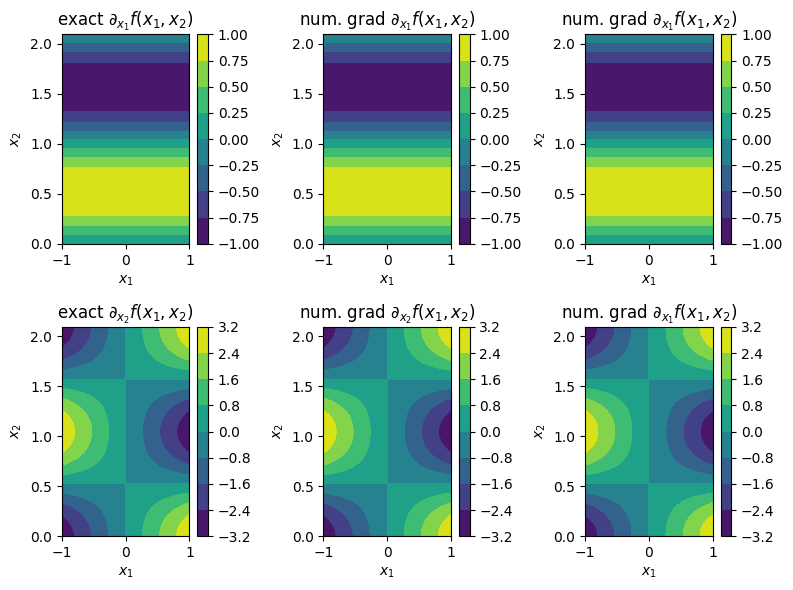

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
cont = ax[0,0].contourf(X1, X2, _df(X1, X2)[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2)$')

cont = ax[0,1].contourf(X1, X2, grad(f, x1, axes=[0]))
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2)$')

cont = ax[0, 2].contourf(X1, X2, grad(f, x1, x2)[:, :, 0])
plt.colorbar(cont)
ax[0, 2].set_xlabel(r'$x_1$')
ax[0, 2].set_ylabel(r'$x_2$')
ax[0, 2].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2)$')

cont = ax[1, 0].contourf(X1, X2, _df(X1, X2)[:, :, 1])
plt.colorbar(cont)
ax[1,0].set_xlabel(r'$x_1$')
ax[1,0].set_ylabel(r'$x_2$')
ax[1,0].set_title(r'exact $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1,1].contourf(X1, X2, grad(f, x2, axes=[1]))
plt.colorbar(cont)
ax[1,1].set_xlabel(r'$x_1$')
ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_title(r'num. grad $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1, 2].contourf(X1, X2, grad(f, x1, x2)[:, :, 1])
plt.colorbar(cont)
ax[1, 2].set_xlabel(r'$x_1$')
ax[1, 2].set_ylabel(r'$x_2$')
ax[1, 2].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2)$')

plt.tight_layout()
plt.show()

### $f: \mathbb{R}^3 \to \mathbb{R}$

Consider:
$$
f(x_1, x_2) = x_1 \sin(a x_2) + x_2 x_3 \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f \\
    \partial_{x_3} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2) + x_3 \\
    x_2
\end{array}
\right)
$$

In [64]:
a=3
_f = lambda x1, x2, x3 : x1 * np.sin(a*x2) + x2 * x3
_df = lambda x1, x2, x3 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2) + x3, x2), axis=-1)

x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(0, 2/a*np.pi, 200)
x3 = np.linspace(0, 10, 300)
X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
f = _f(X1, X2, X3)

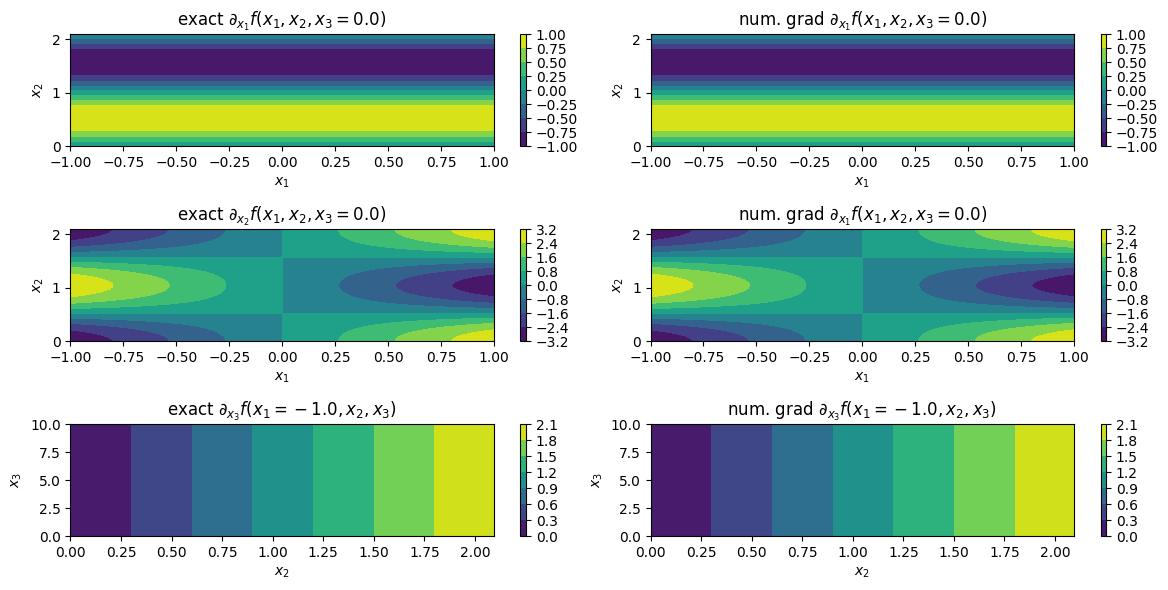

In [65]:
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
cont = ax[0,0].contourf(X1[..., 0], X2[..., 0], _df(X1[..., 0], X2[..., 0], X3[..., 0])[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[0,1].contourf(X1[..., 0], X2[..., 0], grad(f, x1, x2, x3)[..., 0, 0])
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[1, 0].contourf(X1[..., 0], X2[..., 0], _df(X1[..., 0], X2[..., 0], X3[..., 0])[:, :, 1])
plt.colorbar(cont)
ax[1, 0].set_xlabel(r'$x_1$')
ax[1, 0].set_ylabel(r'$x_2$')
ax[1, 0].set_title(r'exact $\partial_{x_2} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[1, 1].contourf(X1[..., 0], X2[..., 0], grad(f, x1, x2, x3)[..., 0, 1])
plt.colorbar(cont)
ax[1, 1].set_xlabel(r'$x_1$')
ax[1, 1].set_ylabel(r'$x_2$')
ax[1, 1].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[2, 0].contourf(X2[0, ...], X3[0, ...], _df(X1[0, ...], X2[0, ...], X3[0, ...])[:, :, 2])
plt.colorbar(cont)
ax[2, 0].set_xlabel(r'$x_2$')
ax[2, 0].set_ylabel(r'$x_3$')
ax[2, 0].set_title(r'exact $\partial_{x_3} f(x_1 = ' + str(x1[0]) + ', x_2, x_3)$')

cont = ax[2, 1].contourf(X2[0, ...], X3[0, ...], grad(f, x1, x2, x3)[0, ..., 2])
plt.colorbar(cont)
ax[2, 1].set_xlabel(r'$x_2$')
ax[2, 1].set_ylabel(r'$x_3$')
ax[2, 1].set_title(r'num. grad $\partial_{x_3} f(x_1 = ' + str(x1[0]) + ', x_2, x_3)$')

plt.tight_layout()
plt.show()